<a href="https://colab.research.google.com/github/siangani/adversary_emmulation/blob/master/cat_1_DIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Loafing and Preprocessing image
image = cv2.imread('lena.png')
# Original image shape
print(f"Original image shape: {image.shape}")

Original image shape: (512, 512, 3)


In [ ]:
# Conversion of lena's colored image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Histogram Calculations
hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])

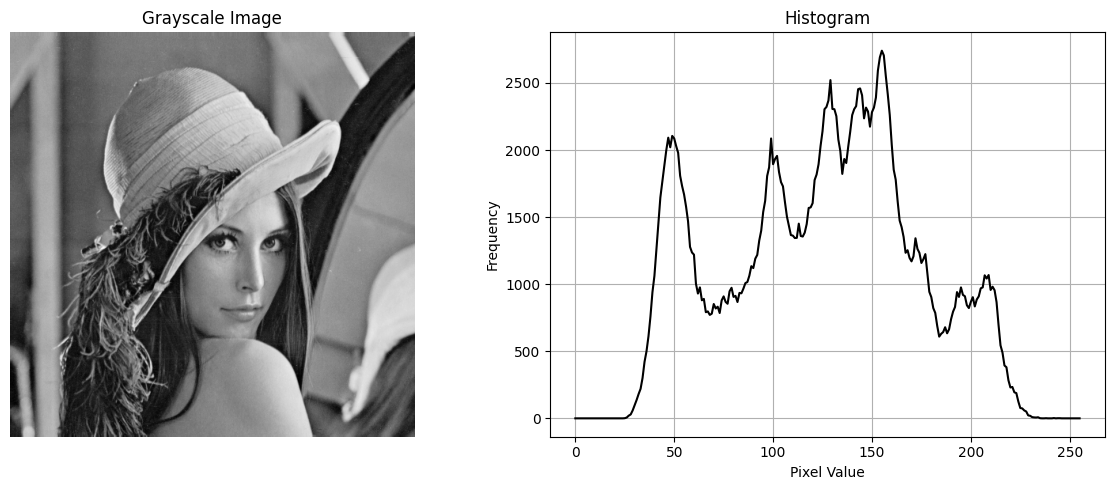

In [ ]:
# Display the grayscale image and its histogram side by side
plt.figure(figsize=(12, 5))
# Display grayscale image
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
# Display histogram
plt.subplot(1, 2, 2)
plt.plot(hist, color='black')
plt.title('Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

# Paert ii. Contrast modification

In [ ]:
# Function to adjust contrast
def adjust_contrast(img, factor):
    """
    Contrast adjustment using:
    new_pixel = alpha * (old_pixel - 128) + 128
    where alpha = factor
    """
    return np.clip(factor * (img - 128) + 128, 0, 255).astype(np.uint8)


In [ ]:
# Create versions with increased and decreased contrast
high_contrast = adjust_contrast(gray_image, 1.5)  # Increase contrast
low_contrast = adjust_contrast(gray_image, 0.5)   # Decrease contrast

# Calculate histograms
original_hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
high_hist = cv2.calcHist([high_contrast], [0], None, [256], [0, 256])
low_hist = cv2.calcHist([low_contrast], [0], None, [256], [0, 256])

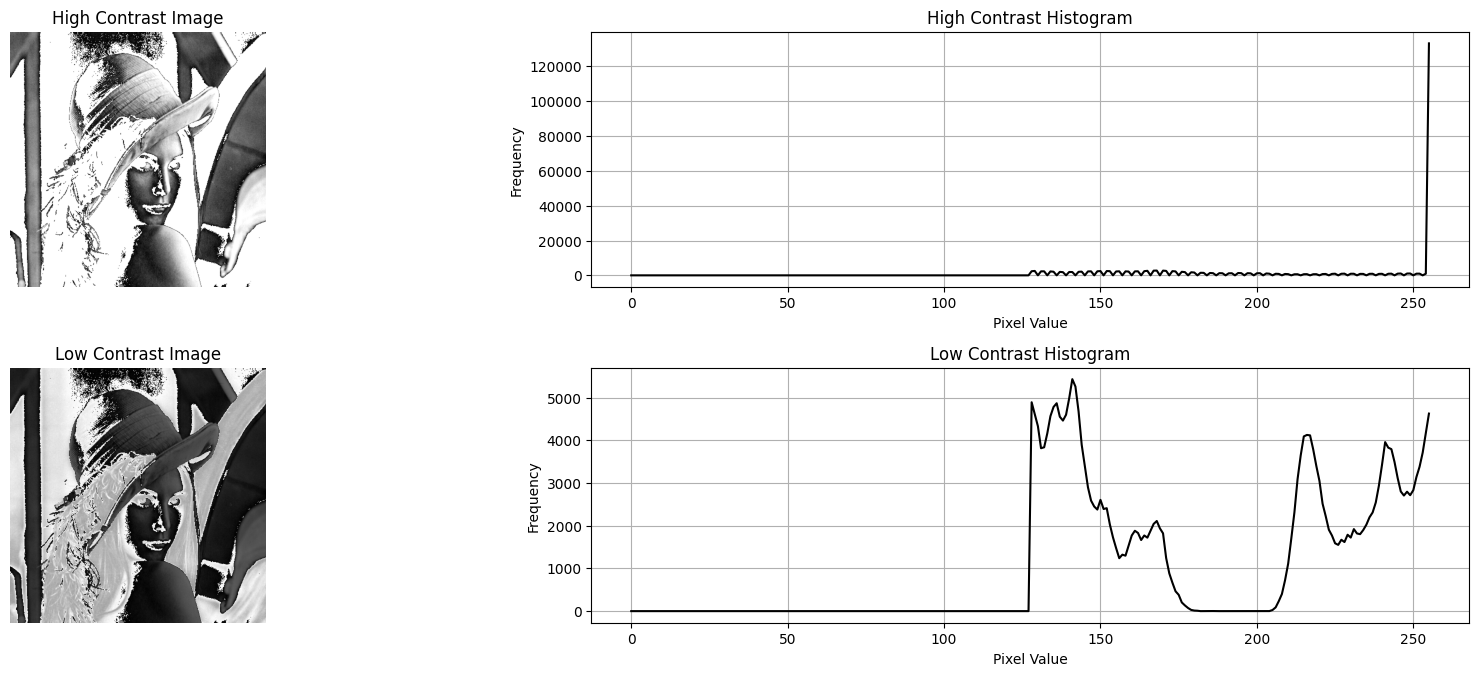

In [ ]:
# Plot images and histograms
plt.figure(figsize=(18, 10))
# High Contrast
plt.subplot(3, 2, 3)
plt.imshow(high_contrast, cmap='gray')
plt.title('High Contrast Image')
plt.axis('off')
plt.subplot(3, 2, 4)
plt.plot(high_hist, color='black')
plt.title('High Contrast Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
# Low Contrast
plt.subplot(3, 2, 5)
plt.imshow(low_contrast, cmap='gray')
plt.title('Low Contrast Image')
plt.axis('off')
plt.subplot(3, 2, 6)
plt.plot(low_hist, color='black')
plt.title('Low Contrast Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


Equalized Image Matrix:
[[5 4 6 5 2]
 [2 5 1 4 6]
 [1 7 6 5 4]
 [2 4 6 4 1]
 [7 4 2 5 4]]


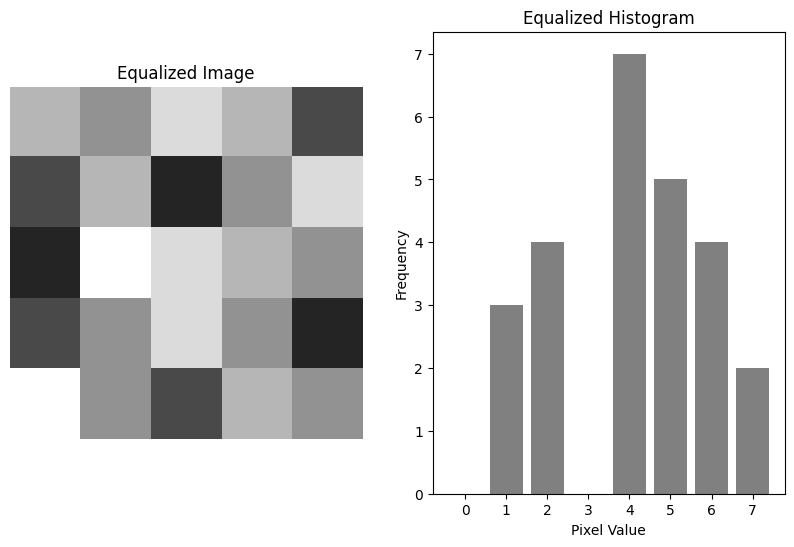

In [ ]:
# Def 5x5 grayscale image (3-bit: values from 0–7)
original_image = np.array([
    [4, 2, 6, 3, 1],
    [1, 4, 0, 2, 6],
    [0, 7, 5, 3, 2],
    [1, 2, 5, 2, 0],
    [7, 2, 1, 3, 2]
])

# Histogram computation
hist, bins = np.histogram(original_image.flatten(), bins=8, range=[0,8])

# CDF computation
cdf = hist.cumsum()
cdf_normalized = cdf / cdf[-1]  # Normalize

# Histogram equalization
L = 8  # Levels for 3-bit image
equalized_vals = np.round(cdf_normalized * (L - 1)).astype(np.uint8)

# Lookup table for original -> equalized values
lookup_table = dict(zip(range(L), equalized_vals))

# Apply mapping to image
equalized_image = np.vectorize(lookup_table.get)(original_image)

print("\nEqualized Image Matrix:")
print(equalized_image)

# Results
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(equalized_image, cmap='gray', vmin=0, vmax=7)
axs[0].set_title("Equalized Image")
axs[0].axis('off')

equalized_hist, _ = np.histogram(equalized_image.flatten(), bins=8, range=[0,8])
axs[1].bar(range(8), equalized_hist, color='gray')
axs[1].set_title("Equalized Histogram")
axs[1].set_xlabel("Pixel Value")
axs[1].set_ylabel("Frequency")
axs[1].set_xticks(range(8))

plt.show()


# Question 2

## Crop the top-left 3x3 patch from the original image


In [ ]:
# Image cropping
patch = original_image[:3, :3]
print("Cropped 3x3 Patch:")
print(patch)

Cropped 3x3 Patch:
[[4 2 6]
 [1 4 0]
 [0 7 5]]


### Convolution with 3x3 Averaging Filter using zero padding


In [ ]:
# Define the 3x3 averaging filter (kernel)
kernel = np.ones((3, 3)) / 9

# Apply zero padding
padded_patch = np.pad(patch, ((1, 1), (1, 1)), mode='constant', constant_values=0)

# Convolve the kernel over the patch
convolved_image = np.zeros_like(patch, dtype=float)
for i in range(patch.shape[0]):
    for j in range(patch.shape[1]):
        convolved_image[i, j] = np.sum(padded_patch[i:i+3, j:j+3] * kernel)

In [ ]:
print("\nStep-by-step Convolution Calculation:")
print(convolved_image)


Step-by-step Convolution Calculation:
[[1.22222222 1.88888889 1.33333333]
 [2.         3.22222222 2.66666667]
 [1.33333333 1.88888889 1.77777778]]


## Implementation of Separable Filter (2 1D Convolutions)


In [ ]:
# 1D kernel for separable filter (horizontal and vertical)
kernel_x = np.array([1, 1, 1]) / 3
kernel_y = np.array([1, 1, 1]) / 3

# First 1D convolution (horizontal direction)
padded_patch_x = np.pad(patch, ((0, 0), (1, 1)), mode='constant', constant_values=0)
conv_x = np.zeros_like(patch, dtype=float)
for i in range(patch.shape[0]):
    for j in range(patch.shape[1]):
        conv_x[i, j] = np.sum(padded_patch_x[i, j:j+3] * kernel_x)

# Second 1D convolution (vertical direction)
padded_patch_y = np.pad(conv_x, ((1, 1), (0, 0)), mode='constant', constant_values=0)
conv_y = np.zeros_like(patch, dtype=float)
for i in range(patch.shape[0]):
    for j in range(patch.shape[1]):
        conv_y[i, j] = np.sum(padded_patch_y[i:i+3, j] * kernel_y)


In [ ]:
print("\nStep-by-step Separable Filter Calculation (2 1D Convolutions):")
print(conv_y)


Step-by-step Separable Filter Calculation (2 1D Convolutions):
[[1.22222222 1.88888889 1.33333333]
 [2.         3.22222222 2.66666667]
 [1.33333333 1.88888889 1.77777778]]


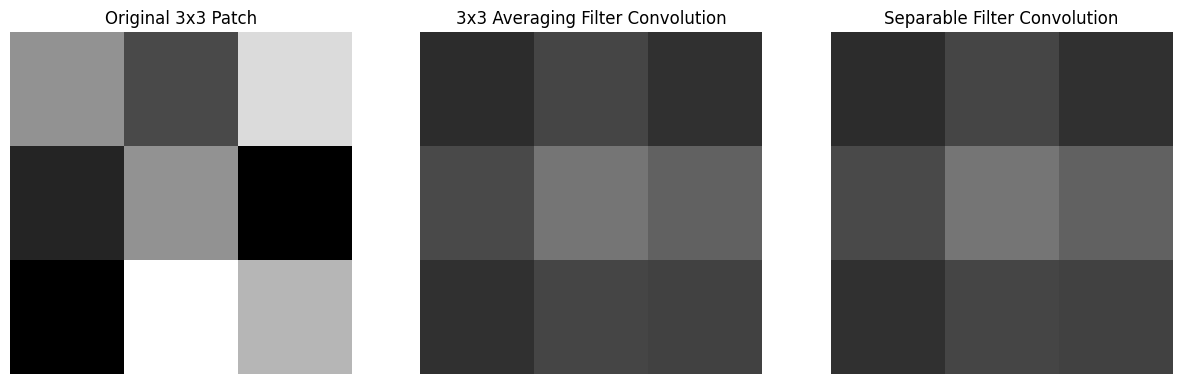

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original patch
axs[0].imshow(patch, cmap='gray', vmin=0, vmax=7)
axs[0].set_title("Original 3x3 Patch")
axs[0].axis('off')

# Convolution with 3x3 kernel
axs[1].imshow(convolved_image, cmap='gray', vmin=0, vmax=7)
axs[1].set_title("3x3 Averaging Filter Convolution")
axs[1].axis('off')
# Convolution with separable filter
axs[2].imshow(conv_y, cmap='gray', vmin=0, vmax=7)
axs[2].set_title("Separable Filter Convolution")
axs[2].axis('off')

plt.show()

## Comparison of computational cost


In [ ]:
print("\nComputational Cost Comparison:")
# Direct 3*3 convolution
direct_convolution_ops = 9 * patch.size

# Separable filter
separable_convolution_ops = 3 * patch.shape[0] * patch.shape[1] * 2

print(f"Direct 3x3 convolution operations: {direct_convolution_ops}")
print(f"Separable filter convolution operations: {separable_convolution_ops}")


Computational Cost Comparison:
Direct 3x3 convolution operations: 81
Separable filter convolution operations: 54


# Question 3

In [ ]:
lena_gray = cv2.cvtColor(lena_color, cv2.COLOR_BGR2GRAY)

# Convert grayscale image to binary by thresholding
_, binary = cv2.threshold(lena_gray, 127, 255, cv2.THRESH_BINARY)

kernel = np.ones((3, 3), np.uint8)

In [ ]:
# Morphological Operations
dilation = cv2.dilate(binary, kernel, iterations=1)
erosion = cv2.erode(binary, kernel, iterations=1)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)


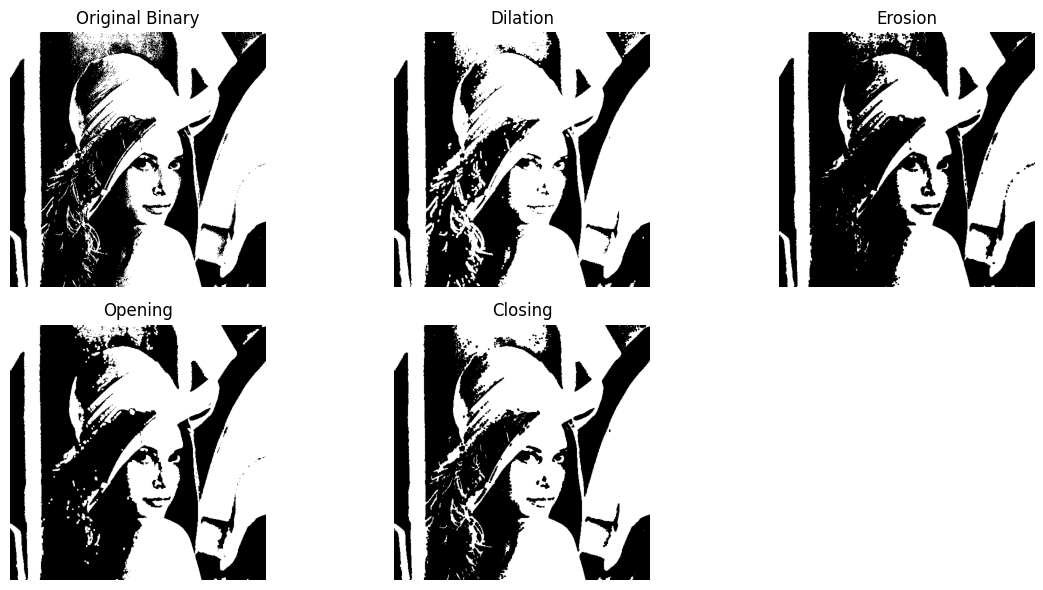

In [ ]:
# Results
titles = ['Original Binary', 'Dilation', 'Erosion', 'Opening', 'Closing']
images = [binary, dilation, erosion, opening, closing]

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

##Custom structuring elemts

In [ ]:
# Default kernel (3x3 square)
kernel_default = np.ones((3, 3), np.uint8)

# Custom kernel (5x5 cross)
kernel_custom = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))

In [ ]:
# Morphological operations with default kernel
dilation_default = cv2.dilate(binary, kernel_default, iterations=1)
erosion_default = cv2.erode(binary, kernel_default, iterations=1)
opening_default = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_default)
closing_default = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_default)

# Morphological operations with custom cross kernel
dilation_custom = cv2.dilate(binary, kernel_custom, iterations=1)
erosion_custom = cv2.erode(binary, kernel_custom, iterations=1)
opening_custom = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_custom)
closing_custom = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_custom)


In [ ]:
# Display all results side by side for comparison
titles = [
    'Dilation (Default)', 'Dilation (Cross)',
    'Erosion (Default)', 'Erosion (Cross)',
    'Opening (Default)', 'Opening (Cross)',
    'Closing (Default)', 'Closing (Cross)'
]
images = [
    dilation_default, dilation_custom,
    erosion_default, erosion_custom,
    opening_default, opening_custom,
    closing_default, closing_custom
]

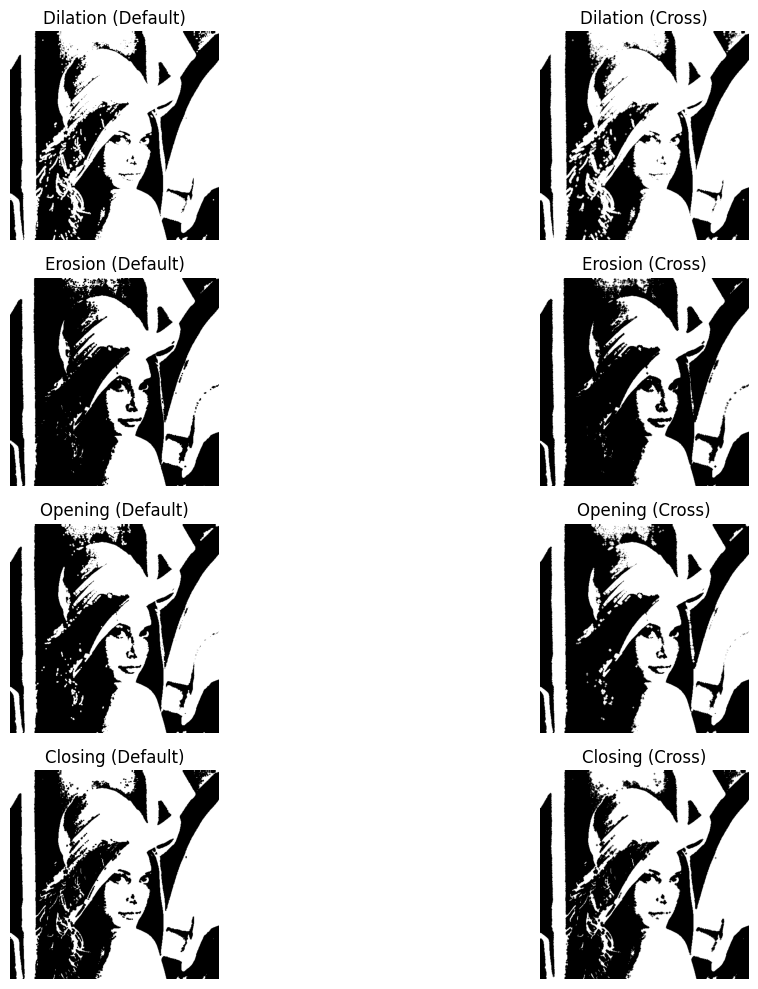

In [ ]:
plt.figure(figsize=(14, 10))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()